## Using Keras RNN to conduct sentiment analysis on naver movie review dataset(NSMC)
* Source: [딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/44249)

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


('ratings_test.txt', <http.client.HTTPMessage at 0x122285970>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [5]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [12]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [13]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [16]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [17]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [18]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146182


<AxesSubplot:>

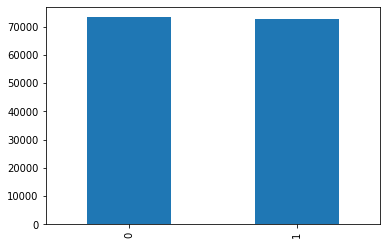

In [19]:
train_data['label'].value_counts().plot(kind = 'bar')

In [20]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

label  count
0      0  73342
1      1  72840


In [21]:
print(train_data.isnull().values.any())

False


In [22]:
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [23]:
train_data.loc[train_data.document.isnull()]

,id,document,label


In [14]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [24]:
print(len(train_data))

146182


In [25]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [26]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [27]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [28]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [29]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


In [30]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [31]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)


['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [32]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [33]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [34]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [36]:
print(tokenizer.word_index)

 42313, '점달': 42314, '재건': 42315, '얼등': 42316, '트컨': 42317, '씨나리오': 42318, '빠징꼬': 42319, '백이이': 42320, '규회': 42321, '으쓱': 42322, '파두콘': 42323, '엔별': 42324, '혔': 42325, '좀촌': 42326, '연간': 42327, '박슈': 42328, '박슈땀시': 42329, '응용': 42330, '뭐밍': 42331, '대업': 42332, '애호가': 42333, '개똥망작': 42334, '자채': 42335, '이비자': 42336, '벨라도나': 42337, '눈부심': 42338, '골든라즈베리상': 42339, 'ㅋㅋㄱㄲ': 42340, '감꿈': 42341, '포테이토': 42342, '렌코': 42343, '륄리': 42344, '뚝도': 42345, '힘그': 42346, 'ㅏㅇㅣ': 42347, '페란': 42348, '낚았': 42349, '배렸음': 42350, '브레너': 42351, '재밋었땅책두있찌': 42352, '머리모양': 42353, '쫌구렌': 42354, '교조': 42355, '외과의': 42356, '엄현경': 42357, '억하심정': 42358, '코바': 42359, '나츠': 42360, '탱탱': 42361, '존꿀잼': 42362, '베이비돌': 42363, '강츄배경': 42364, '잭더자이언트킬러': 42365, '닥돌': 42366, '소진하': 42367, '반댓말': 42368, '덕일': 42369, '인쇄': 42370, '누라리횬': 42371, '바킨': 42372, '알럽': 42373, '왈왈거림': 42374, '목포고': 42375, '목포역': 42376, '탐방': 42377, '전투복': 42378, '쨍쨍거리다': 42379, '케산철': 42380, '카코': 42381, '기계론': 42382, '엔트로피': 42383, '툴': 42384, '이슬람국

In [37]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [38]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 19417


In [39]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [40]:
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [41]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [42]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [43]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


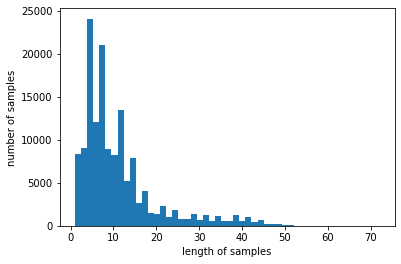

In [44]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [46]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 100.0


In [47]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [48]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [51]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3941 - acc: 0.8219
Epoch 00001: val_acc improved from -inf to 0.84541, saving model to best_model.h5
1939/1939 [==============================] - 129s 66ms/step - loss: 0.3941 - acc: 0.8219 - val_loss: 0.3509 - val_acc: 0.8454
Epoch 2/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3281 - acc: 0.8570
Epoch 00002: val_acc improved from 0.84541 to 0.85534, saving model to best_model.h5
1939/1939 [==============================] - 134s 69ms/step - loss: 0.3281 - acc: 0.8570 - val_loss: 0.3348 - val_acc: 0.8553
Epoch 3/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3025 - acc: 0.8710
Epoch 00003: val_acc improved from 0.85534 to 0.85951, saving model to best_model.h5
1939/1939 [==============================] - 137s 71ms/step - loss: 0.3025 - acc: 0.8710 - val_loss: 0.3253 - val_acc: 0.8595
Epoch 4/15
1939/1939 [==============================] - ETA: 0s - loss: 0.2836 - acc: 0.881

In [52]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 22s 14ms/step - loss: 0.3375 - acc: 0.8547

 테스트 정확도: 0.8547


In [53]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [54]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict('감독 뭐하는 놈이냐?')
sentiment_predict('이 영화 핵노잼 ㅠㅠ')
sentiment_predict('이딴게 영화냐 ㅉㅉ')
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')


94.60% 확률로 긍정 리뷰입니다.

98.88% 확률로 부정 리뷰입니다.

99.45% 확률로 부정 리뷰입니다.

99.91% 확률로 부정 리뷰입니다.

89.02% 확률로 긍정 리뷰입니다.



### Utilizing it to Yonsei Exchange Reviews

In [63]:
import os
from os import fdopen, remove
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [64]:
source = "./data/univ_text_data"
source_abstract = "./data/abstract"
source_specific = "./data/specific"